## Загрузка данных

In [1]:
# !pip3 install sklearn

In [2]:
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
%matplotlib inline



In [4]:
df = pd.read_csv('data/eurlex_data.txt',header=None).rename(columns={0:"label",1:"text"})
y = pd.read_csv('data/eurlex_labels.txt',header=None,sep='\s').rename(index =str,columns={0:"title",1:'label'})
t = df.merge(y,on ='label',how='inner')

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# Всякие распределения #

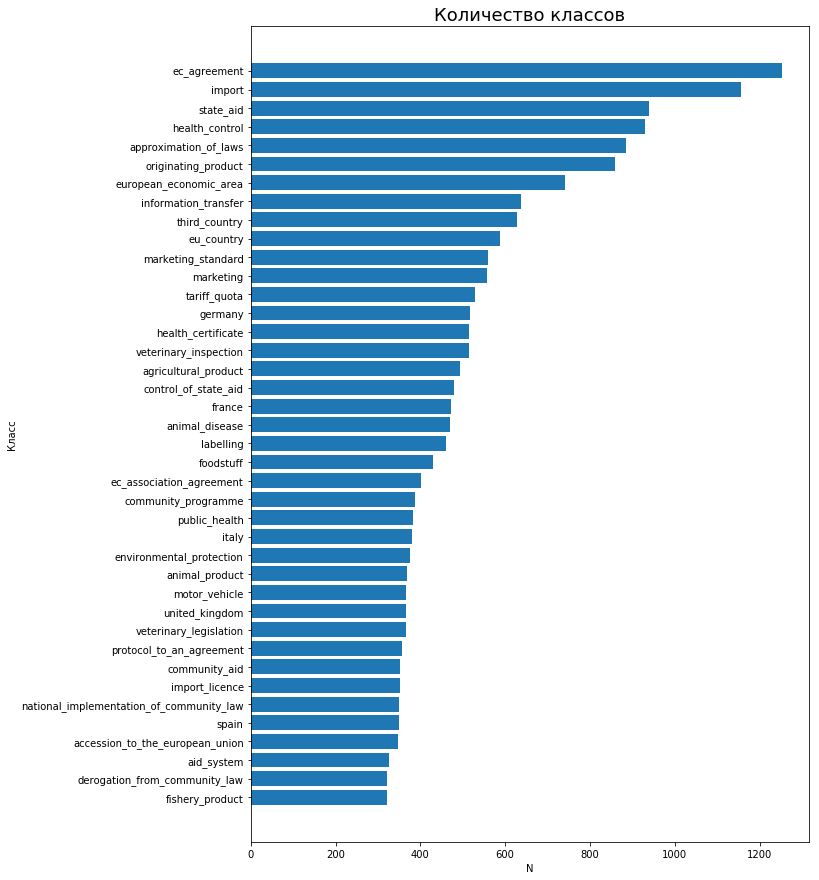

In [5]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

N = 40

plt.figure(figsize = (10, 15))
plt.title('Количество классов', fontsize = 18)
plt.xlabel('N')
plt.ylabel('Класс')
count = list(sorted(Counter(t['title']).items(), key = lambda x: x[1]))[-N:]

lst_x = list([i[0] for i in count])
lst_y = list([i[1] for i in count])

plt.barh(range(len(lst_y)), lst_y)
plt.yticks(range(N), lst_x)

plt.show()

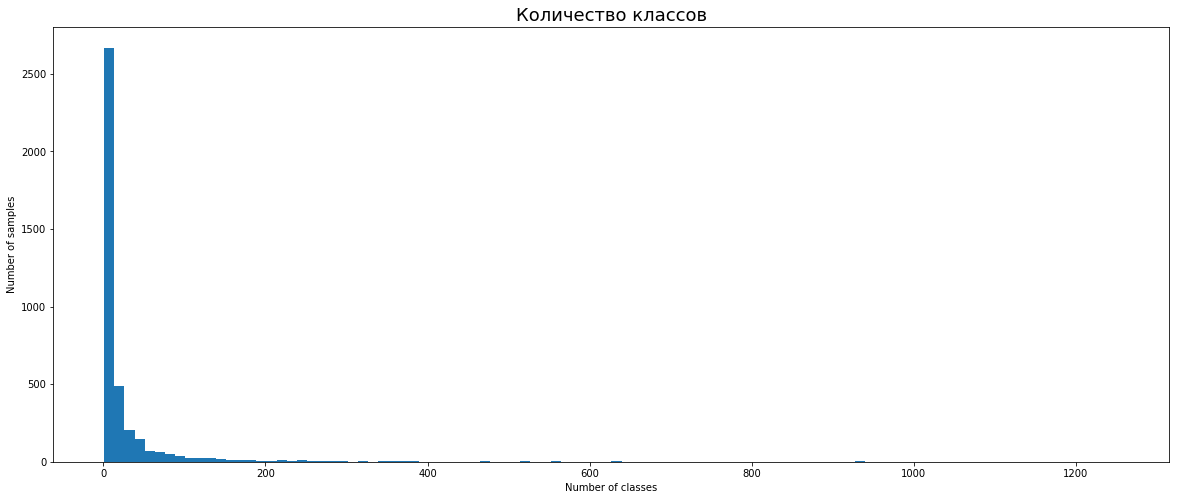

In [6]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

N = 40

plt.figure(figsize = (20, 8))
plt.title('Количество классов', fontsize = 18)
plt.hist(list(Counter(t['title']).values()), bins = 100)
plt.ylabel('Number of samples')
plt.xlabel('Number of classes')
# lst_x = list([i[0] for i in count])
# lst_y = list([i[1] for i in count])

# plt.barh(range(len(lst_y)), lst_y)
# plt.yticks(range(N), lst_x)

plt.show()

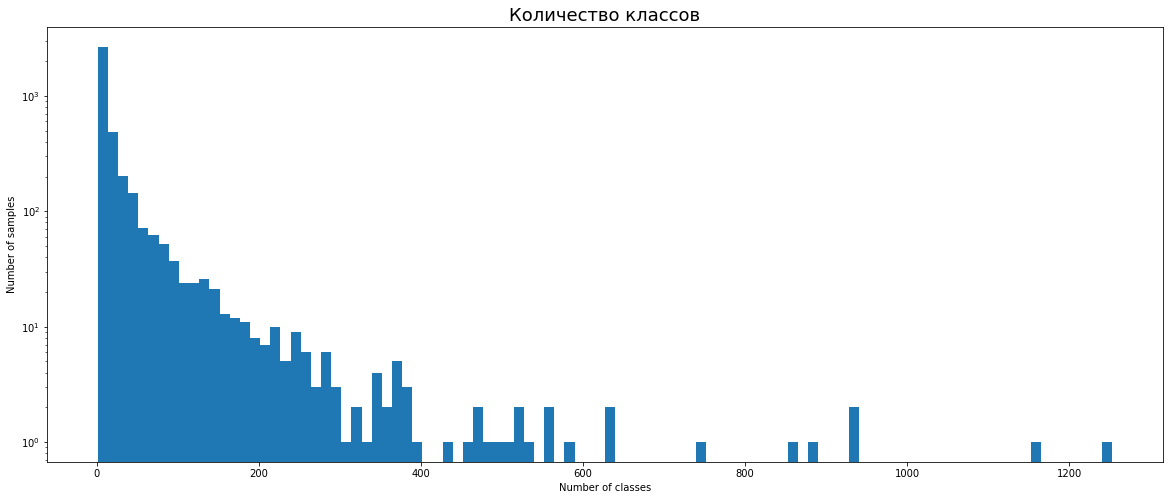

In [7]:
plt.figure(figsize = (20, 8))
plt.title('Количество классов', fontsize = 18)
plt.hist(np.array(list(Counter(t['title']).values())), bins = 100)
plt.ylabel('Number of samples')
plt.xlabel('Number of classes')
plt.yscale('log', nonposy='clip')
plt.show()

In [8]:
symbol_counter = Counter("".join(t['text']))

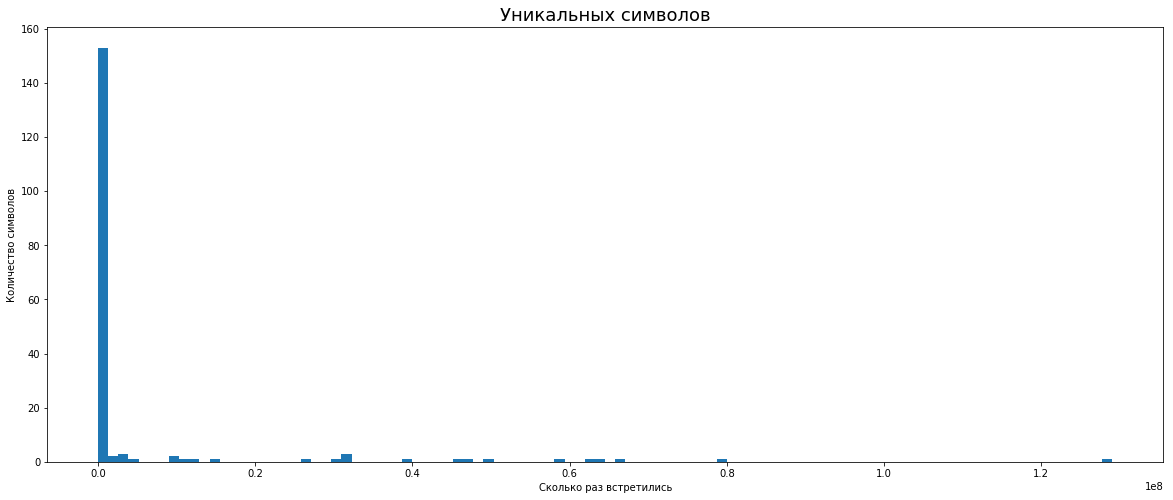

In [9]:
plt.figure(figsize = (20, 8))
plt.title('Уникальных символов', fontsize = 18)
plt.hist(symbol_counter.values(), bins = 100)
plt.ylabel('Количество символов')
plt.xlabel('Сколько раз встретились')
# plt.xscale('log', nonposy='clip')
plt.show()

In [10]:
symbol_counter['e']

78755107

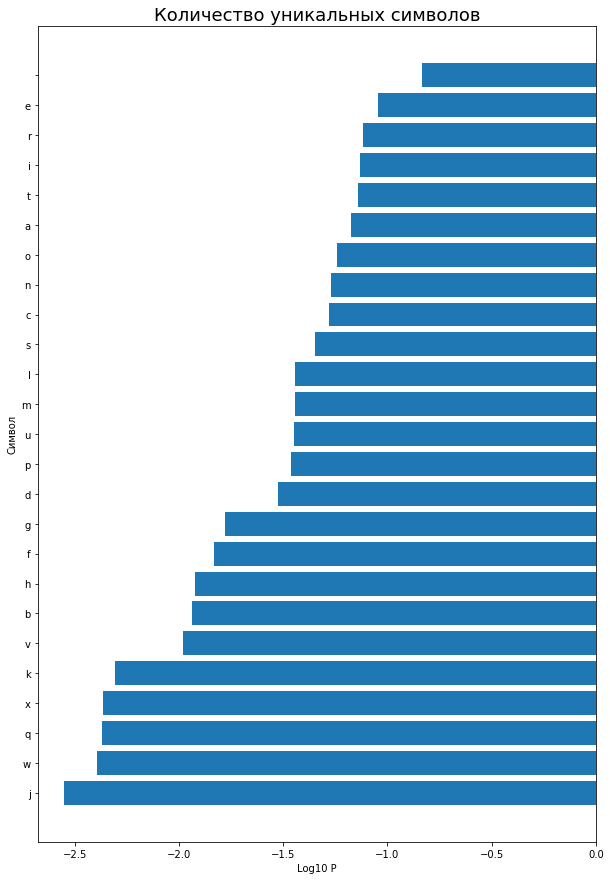

In [11]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

N = 25

plt.figure(figsize = (10, 15))
plt.title('Количество уникальных символов', fontsize = 18)
plt.xlabel('Log10 P')
plt.ylabel('Символ')
norm = sum(symbol_counter.values())
count = list(sorted(symbol_counter.items(), key = lambda x: x[1]))[-N:]

lst_x = list([i[0] for i in count])
lst_y = np.log10(list([i[1]/norm for i in count]))

plt.barh(range(len(lst_y)), lst_y)
plt.yticks(range(N), lst_x)

plt.show()

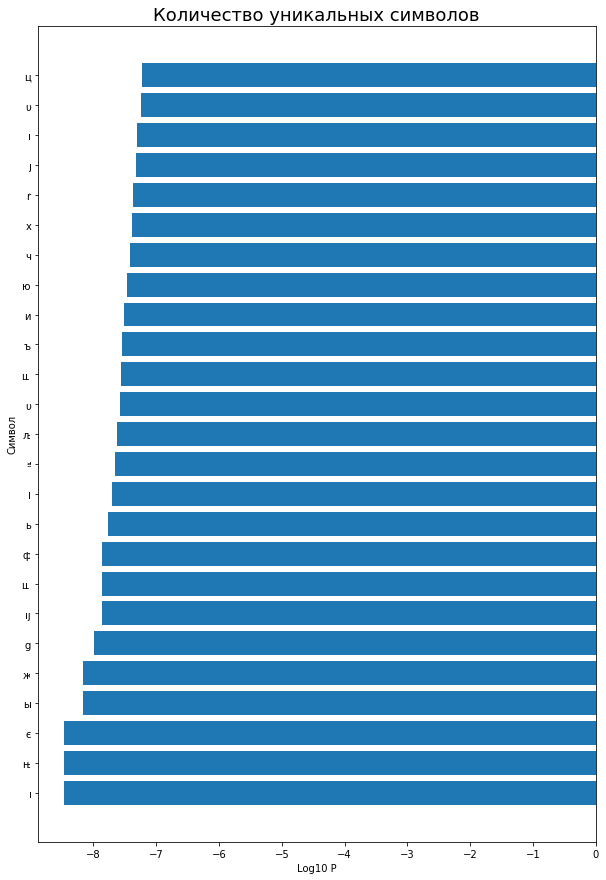

In [12]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

N = 25

plt.figure(figsize = (10, 15))
plt.title('Количество уникальных символов', fontsize = 18)
plt.xlabel('Log10 P')
plt.ylabel('Символ')
norm = sum(symbol_counter.values())
count = list(sorted(symbol_counter.items(), key = lambda x: x[1]))[:N]

lst_x = list([i[0] for i in count])
lst_y = np.log10(list([i[1]/norm for i in count]))

plt.barh(range(len(lst_y)), lst_y)
plt.yticks(range(N), lst_x)

plt.show()

# НАЧАЛО КОДА

Заголовки в классы

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(t['title'])

LabelEncoder()

In [14]:
le.classes_

array(['2164', '2164.0', '3485.0', ..., 'zoology', 'zoonosis',
       'zootechnics'], dtype=object)

In [15]:
t['target'] = le.transform(t['title'])

Определим язык для предобработки текста

In [18]:
# !pip3 install langdetect

In [19]:
from langdetect import detect

In [20]:
def remove_brackets (s):
    return s.replace("\"","").split()
def detect_language (s):
    return detect(s)
def remove_brackets_2 (s):
    return s.replace("\"","")

In [21]:
t['features'] = t[['text','target']].text.apply(remove_brackets_2)

In [22]:
df = t[['features','target']]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['features'], df['target'], test_size=0.1, random_state=42)

In [24]:
#t['language'] = t.features.apply(detect_language)
##df = t[['features','language','target']].copy
##df

Embeddings

Glove (TF-IDF)

In [25]:
with open("data/glove.6B.50d.txt", "rb") as lines:
    glove = {line.split()[0].decode("utf-8"): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [26]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

etree_glove = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(glove)),
    ("extra trees", LinearSVC())])

In [ ]:
e2 = etree_glove.fit(X_train,y_train)

Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

In [ ]:
def tag_docs(docs, col): 
    tagged = docs.apply(lambda r:TaggedDocument(words=simple_preprocess(r[col]),tags=[r.target]),  axis=1) 
    return tagged

In [ ]:
def train_doc2vec_model(tagged_docs): 
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents,dbow_words=0) 
    return doc2vec_model

In [ ]:
def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values 
    targets, regressors = zip([(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
train_data, test_data = train_test_split(df)

In [ ]:
train_tagged = tag_docs(train_data, 'features')
test_tagged = tag_docs(test_data, 'features')

In [ ]:
model = train_doc2vec_model(train_tagged)
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

Fasttext

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import FastText
model = FastText(df['features'], size=4, window=3, min_count=1, iter=10)

Классификация и метрики

In [ ]:
N_top = 10
top_classes = [i[0] for i in sorted(Counter(df['target']).items(), key = lambda x:-x[1])][:N_top]
data = df[df['target'].isin(top_classes)]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['features'], data['target'], 
                                                    test_size=0.1, 
                                                    stratify = data['target'],
                                                    random_state=42)

In [ ]:
vect = TfidfVectorizer(max_features=300)
vect.fit(data['features'])
M_train = vect.transform(X_train)
M_test = vect.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(M_train, y_train)
p_predict =  model.predict_proba(M_test)
class_names = model.classes_

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
def draw_roc_auc(y, p, class_names, threshold = None):
    plt.figure(figsize = (20, 10))
    plt.title('ROC-AUC for classes')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    results = []
    for c, class_name in enumerate(class_names):
        y_true = [int(i == class_name) for i in y]
        if threshold is None:
            y_pred = [i for i in p[:, c]]
        else:
            y_pred = [int(i>threshold) for i in p[:, c]]
        
        fpt, tpr, t = roc_curve(y_true, y_pred)
        s = roc_auc_score(y_true, y_pred)
        results.append(s)
        plt.plot(fpt, tpr, label = f'{class_name} [{round(s, 4)}]')
    plt.legend()
    plt.show()
    print('Mean roc-auc : ', np.mean(results))
    return results

def draw_pr_rec(y, p, class_names, threshold = None):
    plt.figure(figsize = (20, 10))
    plt.title('Precision-Recall for classes')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    results = []
    for c, class_name in enumerate(class_names):
        y_true = [int(i == class_name) for i in y]
        if threshold is None:
            y_pred = [i for i in p[:, c]]
        else:
            y_pred = [int(i>threshold) for i in p[:, c]]
        
        pr, rec, t = precision_recall_curve(y_true, y_pred)
        s = average_precision_score(y_true, y_pred)
        results.append(s)
        plt.plot(rec, pr, label = f'{class_name} [{round(s, 4)}]')
    plt.legend()
    plt.show()
    print('Mean AP : ', np.mean(results))
    return results

res_roc_auc = draw_roc_auc(y_test, p_predict, class_names, threshold=None)

res_pr_rec = draw_pr_rec(y_test, p_predict, class_names, threshold=None)        


In [ ]:
pipe.classes_

# План
    0. Добавить распознование языка
   
    1. Написать функцию scoring, собрать pipeline
        При отрабатывании pipeline, все результаты должны сохраняться
        делать pickle dump
            Предобработанного тектса + название колонок с признаками
            Результаты работы на кросс валидации
            Предварительный подсчет метрик
            
    2. Запустить все методы векторизации текста
        Запустить разные модели Лог Рег, Бустинг, RF
        
    3. Понять почему FastText не такой как другие?
    
    4. Отрисовка

In [94]:
from sklearn.metrics import make_scorer
pipe = Pipeline([('transform', TfidfVectorizer(max_features=100)),
                ('model', LogisticRegression())])

from sklearn.model_selection import cross_val_score
make_scorer(score, needs_proba=True)

def scr(y_true, p_test, class_names, f = roc_auc_score, threshold = None):
    """
      f can be roc_auc_score or average_precision_score
    """
    print(kwargs)
    #p_test = model.predict_proba(X_test)
    mean = []
    for c, class_name in enumerate(model.classes_):
        if threshold is None:
            y_pred = [i for i in p[:, c]]
        else:
            y_pred = [int(i>threshold) for i in p[:, c]]

        s = f(y_true, y_pred)
        mean.append(s)
    return 0 #np.mean(mean)
score = make_scorer(scr, needs_proba=True, class_names = model.classes_ )
cross_val_score(pipe, X_train[:1000], y_train[:1000], cv = 3, scoring=score)

NameError: name 'kwargs' is not defined

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['features'], df['target'], test_size=0.1, random_state=42)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 1000)
X_train_new = vectorizer.fit_transform(X_train)

In [34]:
X_train_new.shape

(92466, 1000)

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0))

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [ ]:
model = LogisticRegression()
model.fit(X_train_new, y_train)
X_test_new = vectorizer.transform(X_test)
p_test_new = model.predict_proba(X_test_new)

In [3]:
import pickle
import numpy as np
import pandas as pd
res = pickle.load(open('/mnt/dump/dirty_dump/fasttext|fast_text|0','rb'))

In [4]:
res.keys()

dict_keys(['classes_', 'y_test_label', 'y_train_label', 'y_train', 'p_test', 'p_train', 'y_test'])

In [6]:
labels = res['y_test_label']

In [7]:
p = res['p_test']

In [9]:
res['classes_']

['__label__1278',
 '__label__2806',
 '__label__1271',
 '__label__3157',
 '__label__1072',
 '__label__1342',
 '__label__3883',
 '__label__3567',
 '__label__3232',
 '__label__1688',
 '__label__3532',
 '__label__2957',
 '__label__1201',
 '__label__873',
 '__label__3512',
 '__label__586',
 '__label__3569',
 '__label__1879',
 '__label__2667',
 '__label__1982',
 '__label__822',
 '__label__3668',
 '__label__3647',
 '__label__3533',
 '__label__3732',
 '__label__1632',
 '__label__1633',
 '__label__1074',
 '__label__3654',
 '__label__1119',
 '__label__3655',
 '__label__1170',
 '__label__1626',
 '__label__2137',
 '__label__881',
 '__label__888',
 '__label__1989',
 '__label__2012',
 '__label__2943',
 '__label__2944',
 '__label__2949',
 '__label__2543',
 '__label__531',
 '__label__876',
 '__label__3311',
 '__label__1841',
 '__label__3014',
 '__label__2169',
 '__label__1097',
 '__label__1866',
 '__label__3534',
 '__label__2446',
 '__label__541',
 '__label__1775',
 '__label__360',
 '__label__668',
 '

In [15]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score

def transform_predict(label, p, classes):
    """
        label, p
        return:
            id_label: predcited_list
    """
    res = {}
    for c, single_label in tqdm(enumerate(label)):
        if single_label not in res:
            res[single_label] = p[c, :]
        if np.abs(res[single_label]-p[c, :]).sum()>1e-9:
            print(np.abs(res[single_label]-p[c, :]).sum())
            raise ValueError('bad')
    return res

def transform_test(df_truth, classes):
    """ y_label_aggregate
       	label	title
        0	53	1779
        1	53	559
        2	53	846
        
       return:
           id_label: one-hot y_list
    """
    if type(classes) is not list:
        classes = list(classes)
        
    res = {}
    for label, obj in tqdm(df_truth.groupby('label')):
        temp = np.zeros(len(classes))
        for single_class in obj['title']:
            temp[classes.index(single_class)] = 1
        res[label] = temp
    return res

def calculate_metric(dict_truth, dict_pred):
    if (len(set(dict_truth.keys())-set(dict_pred.keys()))!=0) or \
       (len(set(dict_pred.keys())-set(dict_truth.keys()))!=0):
            raise ValueError('labels mismatch')
            
    res_roc, res_ap = {}, {}
    for single_label in tqdm(set(dict_truth.keys())):
        p = dict_pred[single_label]
        y = dict_truth[single_label]
        res_roc[single_label] = roc_auc_score(y, p)
        res_ap[single_label] = average_precision_score(y, p)
    return res_roc, res_ap

def calculate(y_aggregate, p, classes):
    print('prepare truth')
    t_truth   = transform_test(y_aggregate, classes=classes)
    print('prepare predict')
    t_predict = transform_predict(y_aggregate['label'].get_values(), p, classes)
    print('calculate metric')
    res_roc, res_ap = calculate_metric(t_truth, t_predict)
    return res_roc, res_ap

# calculate(df,)
# # t_truth   = transform_test(y_test_aggregate, classes=y_classes)
# # t_predict = transform_predict(y_label_test, res_test, y_classes)
# print('train')
# res_roc, res_ap = calculate(y_train_aggregate, res_train, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

# print('test')
# res_roc, res_ap = calculate(y_test_aggregate, res_test, classes=y_classes)
# print('ROC ', np.mean(list(res_roc.values())))
# print('AP  ', np.mean(list(res_ap.values())))
# print('done')

In [17]:
_df_train = pd.DataFrame({'title': res['y_test'],
                   'label': res['y_test_label']})
_p = res['p_test']
# _label = res['y_test_label']
_classes = res['classes_']
calculate(_df_train, _p, _classes)


prepare truth


100%|██████████| 8151/8151 [00:03<00:00, 2431.13it/s]
4644it [00:00, 46429.53it/s]

prepare predict


10275it [00:00, 44701.85it/s]
  0%|          | 30/8151 [00:00<00:27, 296.78it/s]

calculate metric


100%|██████████| 8151/8151 [00:26<00:00, 307.72it/s]


({16385: 0.3987357774968394,
  16388: 0.5152970922882427,
  16390: 0.9646017699115044,
  16391: 0.6806573957016435,
  16392: 0.5790139064475348,
  16393: 0.5307206068268016,
  16395: 0.19772439949431098,
  16400: 0.47686472819216186,
  16401: 0.5160556257901391,
  16402: 0.9742098609355246,
  16403: 0.2503160556257902,
  16405: 0.18887484197218707,
  16406: 0.16687737041719342,
  16408: 0.6136823469903895,
  16417: 0.03868520859671298,
  16420: 0.9226295828065739,
  16421: 0.5115073343449671,
  16422: 0.8960809102402022,
  16424: 0.2585988872028326,
  16425: 0.5241588666835316,
  16426: 0.6389380530973451,
  43: 0.21592920353982303,
  16428: 0.010113780025284458,
  16429: 0.3877086494688923,
  46: 0.9944374209860936,
  16433: 0.8185381891755185,
  16434: 0.672819216182048,
  16435: 0.16763590391908978,
  16436: 0.46724835609509363,
  16439: 0.04500632111251579,
  56: 0.5024020227560051,
  16445: 0.02326169405815426,
  62: 0.4723135271807838,
  65: 0.4685208596713022,
  16450: 0.2874841

In [19]:
"""fast text results"""
import pickle
import numpy as np
import pandas as pd
res = pickle.load(open('/mnt/dump/dirty_dump/fasttext|fast_text|0','rb'))

df_train = pd.DataFrame({'title': res['y_train'],
                        'label': res['y_train_label']})
p_train = res['p_train']

df_test = pd.DataFrame({'title': res['y_test'],
                        'label': res['y_test_label']})
p_test = res['p_test']

classes = res['classes_']



res_roc, res_ap = calculate(df_train, p_train, classes=classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

print('test')
res_roc, res_ap = calculate(df_test, p_test, classes=classes)
print('ROC ', np.mean(list(res_roc.values())))
print('AP  ', np.mean(list(res_ap.values())))
print('done')

prepare truth


100%|██████████| 19308/19308 [00:10<00:00, 1801.13it/s]
5235it [00:00, 52342.44it/s]

prepare predict


92466it [00:02, 45300.06it/s]
  0%|          | 36/19308 [00:00<00:53, 359.26it/s]

calculate metric


100%|██████████| 19308/19308 [00:56<00:00, 340.23it/s]


ROC  0.5016290316372537
AP   0.002835192132391308
done
test
prepare truth


100%|██████████| 8151/8151 [00:03<00:00, 2661.58it/s]
3850it [00:00, 38259.13it/s]

prepare predict


10275it [00:00, 36442.63it/s]
  0%|          | 33/8151 [00:00<00:24, 328.87it/s]

calculate metric


100%|██████████| 8151/8151 [00:24<00:00, 327.42it/s]

ROC  0.49575258399423194
AP   0.0018443614500961263
done


In [20]:
res['classes_']

['__label__1278',
 '__label__2806',
 '__label__1271',
 '__label__3157',
 '__label__1072',
 '__label__1342',
 '__label__3883',
 '__label__3567',
 '__label__3232',
 '__label__1688',
 '__label__3532',
 '__label__2957',
 '__label__1201',
 '__label__873',
 '__label__3512',
 '__label__586',
 '__label__3569',
 '__label__1879',
 '__label__2667',
 '__label__1982',
 '__label__822',
 '__label__3668',
 '__label__3647',
 '__label__3533',
 '__label__3732',
 '__label__1632',
 '__label__1633',
 '__label__1074',
 '__label__3654',
 '__label__1119',
 '__label__3655',
 '__label__1170',
 '__label__1626',
 '__label__2137',
 '__label__881',
 '__label__888',
 '__label__1989',
 '__label__2012',
 '__label__2943',
 '__label__2944',
 '__label__2949',
 '__label__2543',
 '__label__531',
 '__label__876',
 '__label__3311',
 '__label__1841',
 '__label__3014',
 '__label__2169',
 '__label__1097',
 '__label__1866',
 '__label__3534',
 '__label__2446',
 '__label__541',
 '__label__1775',
 '__label__360',
 '__label__668',
 '